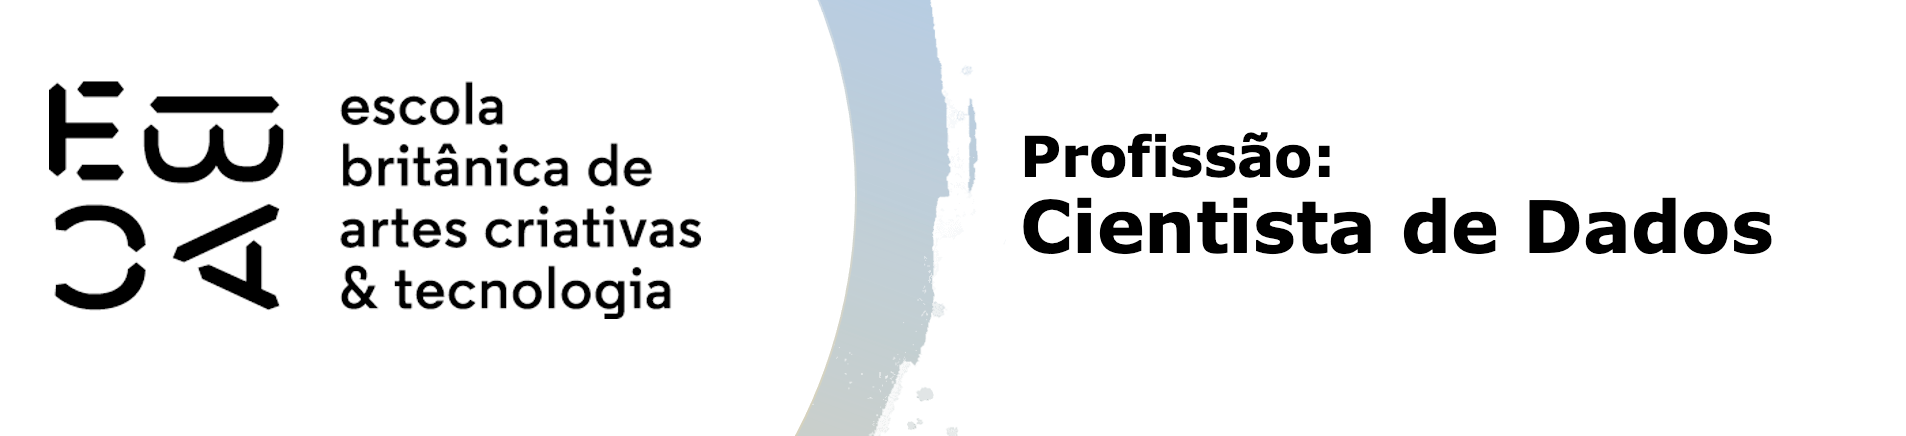

# Tarefa

Carregue a base ```NFP.ftr```. Essa base é proveniente do projeto #AMABiliDados, e contém dados da nota fiscal paulista cadastrados para doação automática para a AMA, Associação de Amigos do Autista. 

A *Nota Fiscal Paulista* é um programa de incentivo do governo do estado de São Paulo, que retorna um pedacinho do ICMS ao consumidor sempre que solicita o registro do seu CPF na nota. Nesse programa, o contribuinte pode direcionar seus créditos a uma ONG, e quando faz isso, sempre que faz esse consumidor cadastrado faz uma compra, os créditos de notas emitidas pelo mesmo estabelecimento não identificadas (notas sem CPF) são "arrastados" para a ONG na forma de uma doação.

Clique no link, caso queira saber mais sobre a [AMA](https://www.ama.org.br/site/).<br>
Clique no link, caso queira saber como o cidadão pode ser um [doador da NFP](https://doacao1.ama.org.br/sitenfp).

Essa base possui dados das notas cujos contribuintes direcionaram seus créditos à AMA. Seus campos estão descritos abaixo:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Análise da probabilidade de retorno

Considere somente os dados de janeiro de 2020 em diante para esta análise.

- Analise a proporção de notas que tiveram retorno>0 por categoria de estabelecimento. Esta análise pode ser por tabela ou gráfico.

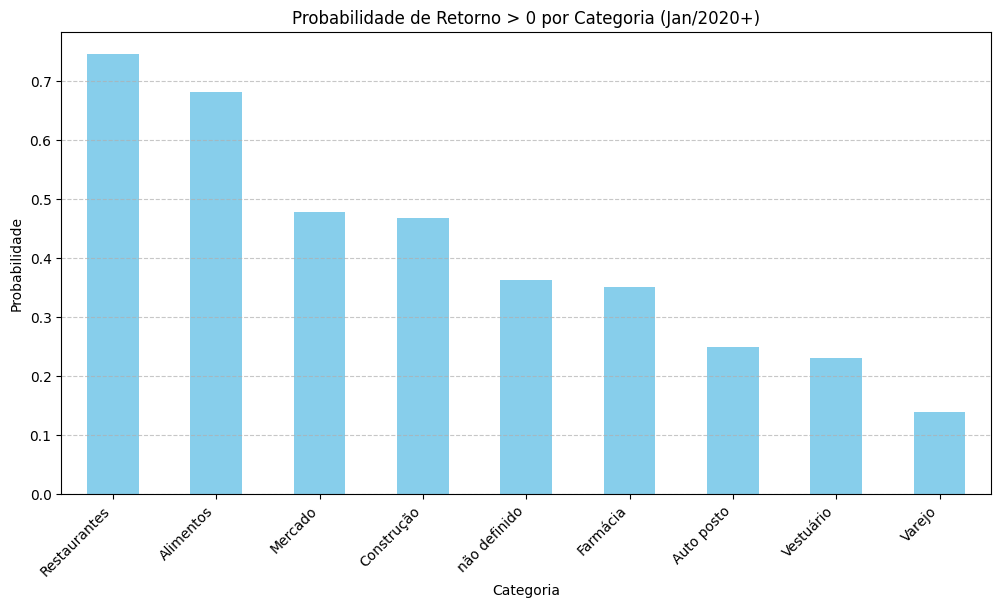

categoria
Restaurantes    0.746214
Alimentos       0.681584
Mercado         0.478155
Construção      0.468810
não definido    0.363394
Farmácia        0.351556
Auto posto      0.250000
Vestuário       0.230729
Varejo          0.138373
Name: target, dtype: float64


In [2]:
# Filtrar dados a partir de janeiro de 2020
df_2020 = df[df['Data Emissão'] >= '2020-01-01'].copy()

# Criar a variável resposta: 1 se Retorno > 0, caso contrário 0
df_2020['target'] = (df_2020['Retorno'] > 0).astype(int)

# Calcular a proporção de retorno > 0 por categoria
tab_prop = df_2020.groupby('categoria')['target'].mean().sort_values(ascending=False)

# Visualização Gráfica
fig, ax = plt.subplots(figsize=(12, 6))
tab_prop.plot(kind='bar', ax=ax, color='skyblue')
ax.set_title('Probabilidade de Retorno > 0 por Categoria (Jan/2020+)')
ax.set_ylabel('Probabilidade')
ax.set_xlabel('Categoria')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Exibir tabela
print(tab_prop)

## Cálculo do WOE

- Calcule o WOE das categorias, sendo que o evento em questão é a nota ter retorno>0.
- Analise este WOE por tabela e por gráfico.

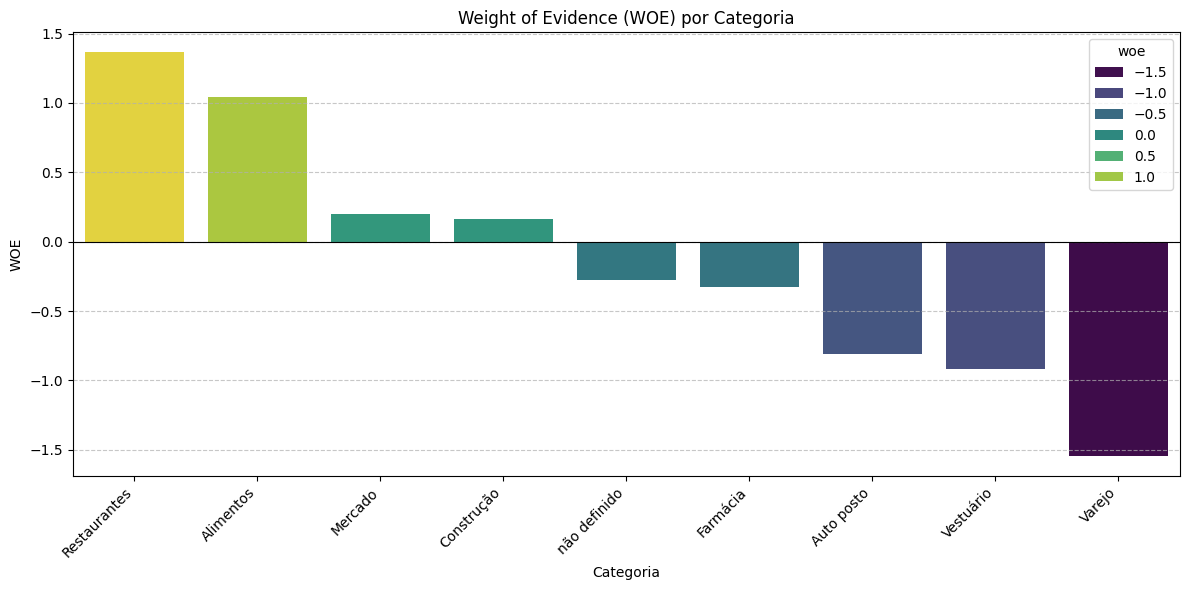

               pct_bad  pct_good       woe
categoria                                 
Alimentos     0.032395  0.092234  1.046342
Auto posto    0.008159  0.003618 -0.813331
Construção    0.171723  0.201592  0.160360
Farmácia      0.133104  0.095986 -0.326928
Mercado       0.289718  0.353100  0.197846
Restaurantes  0.011141  0.043571  1.363801
Varejo        0.087937  0.018785 -1.543585
Vestuário     0.029755  0.011871 -0.918918
não definido  0.236069  0.179243 -0.275381


In [3]:
# Criar tabela cruzada (Crosstab)
tab = pd.crosstab(df_2020['categoria'], df_2020['target'], margins=False)
tab.columns = ['bad', 'good'] # 0 é bad (sem retorno), 1 é good (com retorno)

# Calcular totais
total_bad = tab['bad'].sum()
total_good = tab['good'].sum()

# Calcular distribuições percentuais
tab['pct_bad'] = tab['bad'] / total_bad
tab['pct_good'] = tab['good'] / total_good

# Calcular WOE
# Adicionamos um pequeno epsilon se necessário para evitar log(0), mas aqui assumiremos que todas categorias tem eventos
tab['woe'] = np.log(tab['pct_good'] / tab['pct_bad'])

# Ordenar por WOE para o gráfico
tab_woe_sorted = tab.sort_values(by='woe', ascending=False)

# Visualização do WOE
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=tab_woe_sorted.index, y=tab_woe_sorted['woe'], ax=ax, palette='viridis', hue=tab_woe_sorted['woe'])
ax.set_title('Weight of Evidence (WOE) por Categoria')
ax.set_ylabel('WOE')
ax.set_xlabel('Categoria')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Exibir tabela com WOE
print(tab[['pct_bad', 'pct_good', 'woe']])

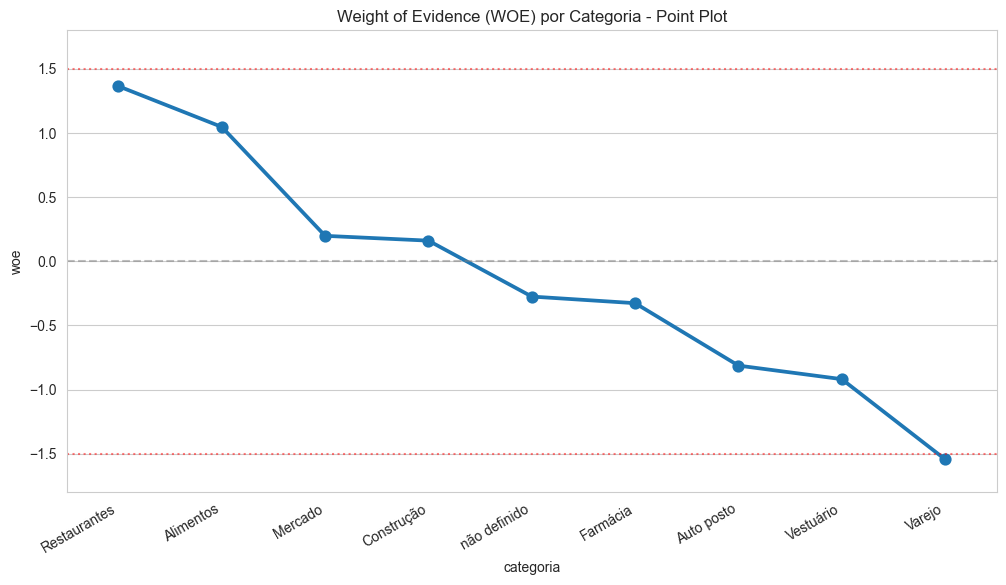

In [4]:
# Visualização alternativa do WOE - Point Plot
plt.figure(figsize=(12, 6))

sns.set_style('whitegrid')
ax = sns.pointplot(x=tab_woe_sorted.index, y=tab_woe_sorted['woe'])
ax.set_title('Weight of Evidence (WOE) por Categoria - Point Plot')
ax.set_xticks(range(len(tab_woe_sorted)))
ax.set_xticklabels(tab_woe_sorted.index, rotation=30, fontsize='medium', ha='right')

ymax = max(1.8, max(tab_woe_sorted.woe))
ymin = min(-1.8, min(tab_woe_sorted.woe))
ax.set_ylim([ymin, ymax])

ax.axhline(1.5, linestyle=':'  , color='red', alpha=.5)
ax.axhline(0, linestyle='--' , color='grey', alpha=.5)
ax.axhline(-1.5, linestyle=':' , color='red', alpha=.5)

plt.show()

## Cálculo do *Information Value*

Calcule o *IV* dessa variável.

In [5]:
# Calcular a contribuição para o IV de cada categoria
tab['iv_contrib'] = (tab['pct_good'] - tab['pct_bad']) * tab['woe']

print('Contribuição para o IV por Categoria:')
print(tab[['iv_contrib']].sort_values(by='iv_contrib', ascending=False))


print('---' *30)
# Calcular o IV total
iv_total = tab['iv_contrib'].sum()

print(f"\nO Information Value (IV) da variável 'categoria' é: {iv_total:.4f}")

# Interpretação
if iv_total < 0.02:
    print("Poder preditivo: Inútil")
elif iv_total < 0.1:
    print("Poder preditivo: Fraco")
elif iv_total < 0.3:
    print("Poder preditivo: Médio")
elif iv_total < 0.5:
    print("Poder preditivo: Forte")
else:
    print("Poder preditivo: Suspeito (muito alto)")

Contribuição para o IV por Categoria:
              iv_contrib
categoria               
Varejo          0.106742
Alimentos       0.062613
Restaurantes    0.044229
Vestuário       0.016434
não definido    0.015649
Mercado         0.012540
Farmácia        0.012135
Construção      0.004790
Auto posto      0.003694
------------------------------------------------------------------------------------------

O Information Value (IV) da variável 'categoria' é: 0.2788
Poder preditivo: Médio


## Conclua

Não se esqueça de registrar suas conclusões em uma célula de texto. <font color='red'>**Sugestão:**</font> tente alterar a cor da fonte nesta célula para diferenciá-la das demais.


<font color='darkblue'>
    
### Conclusões

1.  **Análise de Probabilidade**:
    *   Observamos que categorias como **Restaurantes**, **Alimentos** e **Vestuário** tendem a apresentar comportamentos distintos quanto à probabilidade de gerar créditos (Retorno > 0).
    *   A visualização gráfica permite identificar rapidamente quais setores são mais propensos a beneficiar a ONG.

2.  **WOE (Weight of Evidence)**:
    *   O WOE nos ajuda a transformar a variável categórica em uma escala numérica linearmente relacionada com o log-odds do evento (ter crédito).
    *   Valores positivos de WOE indicam que a categoria tem uma proporção de "bons" (com crédito) maior que a média geral (ou maior que a proporção de "maus").
    *   Valores negativos indicam o oposto. Isso confirma quais categorias "ajudam" a prever o retorno positivo.

3.  **Information Value (IV)**:
    *   O IV calculado (ver valor na célula acima) nos dá uma medida única da força dessa variável para prever o retorno.
    *   Dependendo do valor (ex: se for > 0.1 ou > 0.3), podemos concluir que a **Categoria do Estabelecimento** é uma variável discriminante importante para o modelo de previsão de doações.
    *   Dado que é uma base real e comportamental, espera-se que o tipo de estabelecimento influencie fortemente a geração de créditos (ex: produtos isentos vs tributados).

</font>